In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from __future__ import absolute_import, print_function

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import gpflow
import numpy as np


In [3]:
import tensorflow as tf

from gpflow import likelihoods
from gpflow import settings

from gpflow.params import DataHolder
from gpflow.decors import name_scope, autoflow, params_as_tensors
from gpflow.densities import multivariate_normal

from gpflow.models.model import GPModel


In [4]:
class WGPR(GPModel):
    """
    Weighted Gaussian Process Regression.
    This is a vanilla implementation of GP regression with a Gaussian
    likelihood.  Multiple columns of Y are treated independently.
    The log likelihood i this models is sometimes referred to as the 'marginal log likelihood', and is given by
    .. math::
       \\log p(\\mathbf y \\,|\\, \\mathbf f) = \\mathcal N\\left(\\mathbf y\,|\, 0, \\mathbf K + \\sigma_n \\mathbf Omega^{-1}\\right)
    """
    def __init__(self, wts, X, Y, kern, mean_function=None, **kwargs):
        """
        wts is a weight vector, length N
        X is a data matrix, size N x D
        Y is a data matrix, size N x R
        kern, mean_function are appropriate GPflow objects
        """
        likelihood = likelihoods.Gaussian()
        X = DataHolder(X)
        Y = DataHolder(Y)
        GPModel.__init__(self, X, Y, kern, likelihood, mean_function, **kwargs)
        self.num_latent = Y.shape[1]
        self.inv_wts = DataHolder(1 / wts)
        
    @name_scope('likelihood')
    @params_as_tensors
    def _build_likelihood(self):
        """
        Construct a tensorflow function to compute the likelihood.
            \log p(Y | theta).
        """
        K = self.kern.K(self.X) + tf.diag(self.inv_wts) * self.likelihood.variance
        L = tf.cholesky(K)
        m = self.mean_function(self.X)

        return multivariate_normal(self.Y, m, L)

    @name_scope('predict')
    @params_as_tensors
    def _build_predict(self, Xnew, full_cov=False):
        """
        Xnew is a data matrix, point at which we want to predict
        This method computes
            p(F* | Y )
        where F* are points on the GP at Xnew, Y are noisy observations at X.
        """
        Kx = self.kern.K(self.X, Xnew)
        K = self.kern.K(self.X) + tf.diag(self.inv_wts) * self.likelihood.variance
        #K = self.kern.K(self.X) + tf.eye(tf.shape(self.X)[0], dtype=settings.tf_float) * self.likelihood.variance
        L = tf.cholesky(K)
        A = tf.matrix_triangular_solve(L, Kx, lower=True)
        V = tf.matrix_triangular_solve(L, self.Y - self.mean_function(self.X))
        fmean = tf.matmul(A, V, transpose_a=True) + self.mean_function(Xnew)
        if full_cov:
            fvar = self.kern.K(Xnew) - tf.matmul(A, A, transpose_a=True)
            shape = tf.stack([1, 1, tf.shape(self.Y)[1]])
            fvar = tf.tile(tf.expand_dims(fvar, 2), shape)
        else:
            fvar = self.kern.Kdiag(Xnew) - tf.reduce_sum(tf.square(A), 0)
            fvar = tf.tile(tf.reshape(fvar, (-1, 1)), [1, tf.shape(self.Y)[1]])
        return fmean, fvar

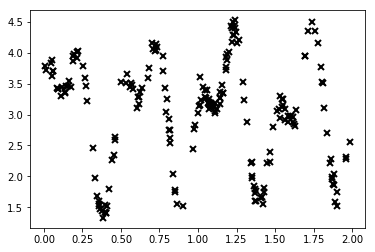

In [4]:
N = 200
X = 2*np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
plt.plot(X, Y, 'kx', mew=2)


In [5]:
m = gpflow.models.GPR(X, Y, kern=gpflow.kernels.RBF(1, lengthscales=[.1]))
m.likelihood.variance = 0.01
m.compile()

#wts = np.ones(X.shape[0]) #np.random.rand(X.shape[0]) < .1
#m = WGPR(wts, X, Y, kern=gpflow.kernels.RBF(1, lengthscales=[.1]))
#m.likelihood.variance = 0.01
#m.compile()

def plot(m, wts=None):
    xx = np.linspace(-0.2, 2.2, 100)[:,None]
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'b', lw=2)
    if wts is not None:
        plt.plot(X[wts > 0], Y[wts > 0], 'ro', mew=2)
    plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
    plt.xlim(-0.2, 2.2)
    plt.show()
    
    plt.plot(xx, np.sqrt(var[:,0]))
    plt.yscale('log')
    plt.show()
plot(m, wts)

NameError: name 'X' is not defined

In [6]:
import sklearn
import sklearn.cluster

n_clusters = 30
XY, assignments, _ = sklearn.cluster.k_means(np.concatenate([X, Y], axis=1), n_clusters)
wts = np.zeros(n_clusters)
for i in assignments:
    wts[i] += 1
nz_inds = wts != 0
Xw = XY[nz_inds,0]
Yw = XY[nz_inds,1]
#wts = wts[nz_inds]
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(Xw, Yw, 'ro', mew=2)
plt.show()

NameError: name 'X' is not defined

/usr/local/lib/python3.5/dist-packages/gpflow/densities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


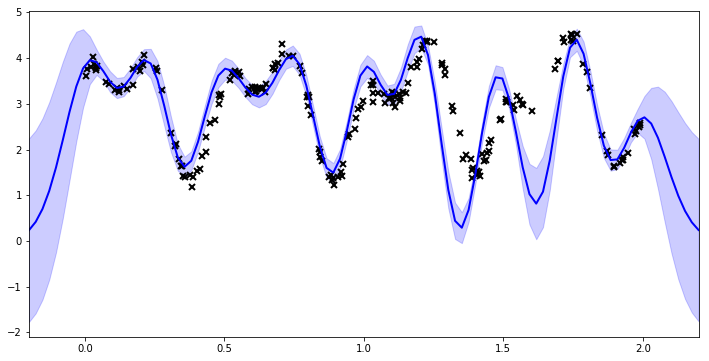

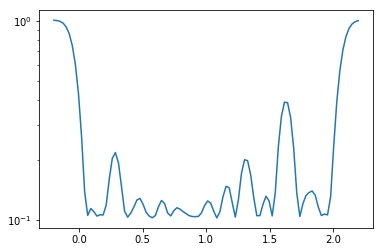

In [95]:
wm = WGPR(wts, Xw[:,None], Yw[:,None], kern=gpflow.kernels.RBF(1, lengthscales=[.1]))
wm.likelihood.variance = 0.01
wm.compile()
plot(wm)

In [7]:
#@autoflow(settings.tf_float, [None, None])
#@params_as_tensors
def exact_fw_gpr_hilbert_coreset(K, M):
    # sigma_n
    norms = tf.sqrt(tf.diag_part(K))
    # sigma
    norm_sum = tf.reduce_sum(norms)
    # <L, L_n/sigma_n>
    inner_prods = tf.reduce_sum(K, axis=1) / norms
    init_index = tf.argmax(inner_prods)
    wts = tf.Variable(tf.zeros_like(inner_prods))
    tf.scatter_add(wts, init_index, norm_sum / norms[init_index])
    # <L(w), L_n/sigma_n>
    weighted_inner_prods = tf.Variable(wts[init_index] * K[init_index,:] / norms)
    for i in range(M):
        new_index = tf.argmax(inner_prods - weighted_inner_prods)
        step_size = 1. / (i + 2.)
        tf.assign(wts, tf.scalar_mul(1 - step_size, wts))
        tf.scatter_add(wts, new_index, step_size * norm_sum / norms[new_index])
        tf.assign(weighted_inner_prods, tf.scalar_mul(1 - step_size, weighted_inner_prods))
        tf.assign_add(weighted_inner_prods, step_size * wts[new_index] * K[new_index,:] / norms)
    return wts


def exact_fw_gpr_hilbert_coreset_no_tf(K, M):
    # sigma_n
    norms = np.sqrt(np.diag(K)) 
    # sigma
    norm_sum = np.sum(norms)
    # <L, L_n/sigma_n>
    inner_prods = np.sum(K, axis=1) / norms 
    init_index = np.argmax(inner_prods) 
    wts = np.zeros_like(inner_prods)
    wts[init_index] = norm_sum / norms[init_index]
    # <L(w), L_n/sigma_n>
    weighted_inner_prods = wts[init_index] * K[init_index,:] / norms
    for i in range(M):
        objective = inner_prods - weighted_inner_prods
        new_index = np.argmax(objective)
        #step_size = 1. / (i + 2.)
        LwLw = np.sum(wts * norms * weighted_inner_prods)
        LLw = np.sum(norms * weighted_inner_prods)
        denom = norm_sum**2 + LwLw - 2 * norm_sum * weighted_inner_prods[new_index]
        step_size = (objective[new_index] + LwLw - LLw) / denom
        #print(step_size)
        wts *= 1 - step_size
        wts[new_index] += step_size * norm_sum / norms[new_index]
        weighted_inner_prods *= 1 - step_size
        #the below commented out line has a bug; the line after fixes it with O(N) cost
        #weighted_inner_prods += step_size * wts[new_index] * K[new_index,:] / norms
        weighted_inner_prods += step_size * norm_sum / norms[new_index]*K[new_index, :]/norms
        #the below line is another fix, but it has O(MN) cost (recomputes full weighted sum)
        #weighted_inner_prods = (wts[wts>0][:,np.newaxis]*K[wts>0,:]).sum(axis=0)/norms

    return wts



composite_kernel_scale = 0.11547005383792516


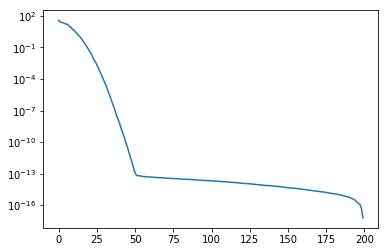

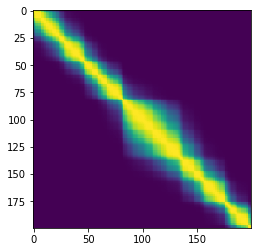

M = 30
||wts||_0 = 24
||wts||_1 = 199.99999999999997


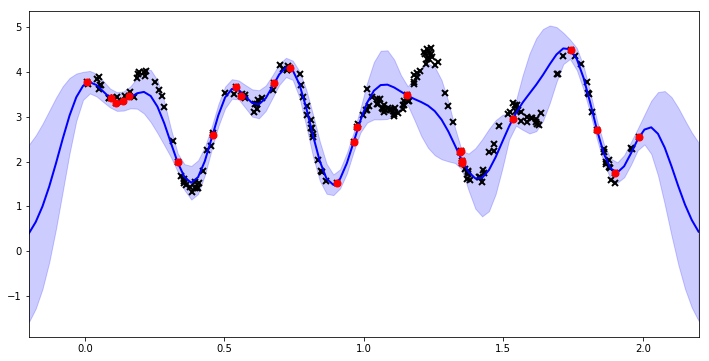

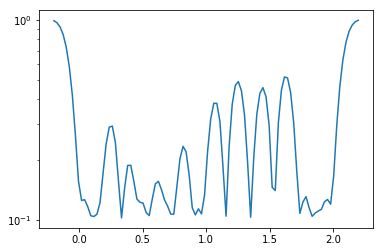

In [9]:
def dist2_matrix(X, Y=None):
    """
    Construct a pairwise Euclidean distance **squared** matrix of size
    X.shape[0] x Y.shape[0]
    """
    sx = np.sum(X**2, 1)
    if Y is None:
        sy = sx
        Y = X
    else: 
        sy = np.sum(Y**2, 1)
    D2 = sx[:, np.newaxis] - 2.0*np.dot(X, Y.T) + sy[np.newaxis, :] 
    return D2

# ideal case
#_, K_post = m.predict_f_full_cov(X)
#K_post = np.squeeze(K_post)
D2 = dist2_matrix(X)
gamma = .1
alpha = 0
composite_kernel_factor = .25 * (1/gamma**2 + 1/(2*gamma**2 - alpha**2))
#print('composite_kernel_factor =', composite_kernel_factor)
print('composite_kernel_scale =', np.sqrt(1/(2 * composite_kernel_factor)))
K = np.exp(- composite_kernel_factor * D2)
svs = np.linalg.svd(K, compute_uv=False)
plt.plot(svs)
plt.yscale('log')
plt.show()

Xsorted = np.sort(X, 0)
D2sorted = dist2_matrix(Xsorted)
Ksorted = np.exp(- composite_kernel_factor * D2sorted)
plt.imshow(Ksorted)
plt.show()

M = 30 #int(K_post.shape[0]**(1/3.) + 1)
print('M =', M)
wts = exact_fw_gpr_hilbert_coreset_no_tf(K, M-1)
pos_wt_inds = wts > 0
print('||wts||_0 =', np.sum(pos_wt_inds))
print('||wts||_1 =', np.sum(wts))

wm = WGPR(wts[pos_wt_inds], X[pos_wt_inds], Y[pos_wt_inds], kern=gpflow.kernels.RBF(1, lengthscales=[gamma]))
wm.likelihood.variance = 0.01
wm.compile()
plot(wm, wts)

In [8]:
# ideal case
#_, K_post = m.predict_f_full_cov(X)
#K_post = np.squeeze(K_post)
D2 = dist2_matrix(X)
gamma = .1
alpha = 0
composite_kernel_factor = .25 * (1/gamma**2 + 1/(2*gamma**2 - alpha**2))
#print('composite_kernel_factor =', composite_kernel_factor)
print('composite_kernel_scale =', np.sqrt(1/(2 * composite_kernel_factor)))
K = np.exp(- composite_kernel_factor * D2)
svs = np.linalg.svd(K, compute_uv=False)
plt.plot(svs)
plt.yscale('log')
plt.show()

Xsorted = np.sort(X, 0)
D2sorted = dist2_matrix(Xsorted)
Ksorted = np.exp(- composite_kernel_factor * D2sorted)
plt.imshow(Ksorted)
plt.show()



like_var = 0.01
gamma_r = gamma
Xsq = (X**2).sum(axis=1)
Dsq = Xsq[:, np.newaxis] + Xsq - 2*X.dot(X.T)
K = np.exp(-Dsq/(2.*gamma**2))
Kr = np.exp(-Dsq/(2.*gamma_r**2))


#get muhat, khat via exact inference
muhat = K.dot(np.linalg.inv(K+like_var*np.eye(K.shape[0]))).dot(Y)
khat = K - K.dot(np.linalg.inv(K+like_var*np.eye(K.shape[0]))).dot(K)

#get muhat, khat via nystrom

coreset_K = (1./like_var**2)*Kr*(khat + (muhat - Y)*(muhat-Y).T)

M = 30 #int(K_post.shape[0]**(1/3.) + 1)
print('M =', M)
#wts = exact_fw_gpr_hilbert_coreset_no_tf(K, M-1)
wts = exact_fw_gpr_hilbert_coreset_no_tf(coreset_K, M-1)
pos_wt_inds = wts > 0
print('||wts||_0 =', np.sum(pos_wt_inds))
print('||wts||_1 =', np.sum(wts))

wm = WGPR(wts[pos_wt_inds], X[pos_wt_inds], Y[pos_wt_inds], kern=gpflow.kernels.RBF(1, lengthscales=[gamma]))
wm.likelihood.variance = 0.01
wm.compile()
plot(wm, wts)

NameError: name 'dist2_matrix' is not defined

In [11]:
X = np.random.rand(100, 10)
y = X.sum(axis=0)
K = X.dot(X.T)
wts = exact_fw_gpr_hilbert_coreset_no_tf(K, 100)
print(y)
print((wts[:,np.newaxis]*X).sum(axis=0))


[53.56004647 51.30322926 52.18910101 45.50676299 52.74053037 54.25506545
 54.83004934 52.64848026 46.0528684  50.6548912 ]
[53.56004653 51.30322928 52.18910103 45.50676301 52.74053034 54.25506549
 54.83004939 52.64848023 46.05286839 50.65489128]
